# Import libraries

In [1]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
from sage import MarginalImputer, PermutationEstimator

from sklearn.datasets import make_spd_matrix
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

# Generate a gaussian linear model for a given design of informative features

In [2]:
def generate_gaussian_lm(
    n_sample=1000,
    n_feature=10,
    n_informative=10,
    n_redundant=0,
    noise_scale=0.1,
    informative_mean=np.zeros(10),
    informative_covariance=np.eye(10),
    informative_weights=None,
    random_state=None,
):
    rng = check_random_state(random_state)

    n_noise = n_feature - (n_informative + n_redundant)
    assert n_noise >= 0

    assert informative_mean.shape == (n_informative,)
    assert informative_covariance.shape == (n_informative, n_informative)
    X = rng.multivariate_normal(informative_mean, informative_covariance, n_sample)

    if n_redundant > 0:
        X_redundant = np.zeros((n_sample, n_redundant))
        for i in range(n_redundant):
            columns_to_sum = rng.choice(
                n_informative, rng.randint(1, n_informative), replace=False
            )
            X_redundant[:, i] = X[:, columns_to_sum].sum(axis=1) + rng.normal(
                0, 0.5, n_sample
            )
        X = np.hstack([X, X_redundant])

    if n_noise > 0:
        X_noise = rng.multivariate_normal(np.zeros(n_noise), np.eye(n_noise), n_sample)
        X = np.hstack([X, X_noise])
    assert X.shape == (n_sample, n_feature)

    if informative_weights is None:
        informative_weights = rng.rand(n_informative)
    assert len(informative_weights) == n_informative
    model_weights = np.concat(
        [informative_weights, np.zeros(n_redundant), np.zeros(n_noise)]
    )
    y = np.dot(X, model_weights) + rng.normal(0, noise_scale, n_sample)

    return X, y, model_weights


# Compute the exact SAGE values for this model

In [3]:
def expected_conditional_variance_reduction(S, i, Sigma, w):
    """
    Computes the expected variance reduction in the conditional expectation of Y
    when adding feature X_i to a conditioning set X_S, under the assumption that:

    - X ~ N(mu, Sigma) is a multivariate normal vector of features
    - Y = w^T X + epsilon, with zero-mean Gaussian noise

    The quantity computed is:
        E[Var(E[Y | X_S, X_i] | X_S)] = Var(Y | X_S) - Var(Y | X_S, X_i)

    Since Y is linear in X and noise is centered and independent of X, this simplifies to:
        w^T (Cov[X | X_S] - Cov[X | X_S, X_i]) w

    Parameters:
    - S (list or array of int): indices of features in the conditioning set X_S
    - i (int): index of the feature X_i to evaluate (must not be in S)
    - Sigma (ndarray): covariance matrix of X (shape d x d)
    - w (ndarray): weight vector in the linear model Y = w^T X (shape d,)

    Returns:
    - float: the expected conditional variance reduction
    """
    S = list(S)
    if i in S:
        raise ValueError("Feature index i should not be in S")

    A = S + [i]

    # Extract relevant submatrices from Sigma
    Sigma_SS = Sigma[np.ix_(S, S)]
    Sigma_SX = Sigma[:, S]
    Sigma_XS = Sigma_SX.T

    Sigma_AA = Sigma[np.ix_(A, A)]
    Sigma_AX = Sigma[:, A]
    Sigma_XA = Sigma_AX.T

    # Compute conditional covariances
    cov_given_S = Sigma - Sigma_SX @ np.linalg.solve(Sigma_SS, Sigma_XS)
    cov_given_A = Sigma - Sigma_AX @ np.linalg.solve(Sigma_AA, Sigma_XA)

    # Compute the difference in explained variance
    delta_cov = cov_given_S - cov_given_A
    result = w.T @ delta_cov @ w

    return result


In [4]:
def compute_exact_sage(i, Sigma, w):
    """
    Computes the average marginal contribution of feature i:

        (1/d) * sum_{S ⊆ D^{-i}} (1 / C(d-1, |S|)) * E[Var(E[Y | X_S, X_i] | X_S)]

    where:
    - D = {0, 1, ..., d-1} is the set of all feature indices
    - S runs over all subsets of D^{-i}
    - X ~ N(mu, Sigma), Y = w^T X + noise
    - Only signal (w^T X) matters for this computation

    Parameters:
    - i (int): index of the feature of interest
    - Sigma (ndarray): covariance matrix of X (shape d x d)
    - w (ndarray): weight vector in Y = w^T X (shape d,)

    Returns:
    - float: SAGE value of feature i
    """
    d = len(w)
    D_minus_i = [j for j in range(d) if j != i]
    total = 0.0

    for k in range(d):  # |S| = 0 to d-1
        subsets_of_size_k = list(itertools.combinations(D_minus_i, k))
        weight = 1 / math.comb(d - 1, k)
        for S in subsets_of_size_k:
            v = expected_conditional_variance_reduction(S, i, Sigma, w)
            total += weight * v

    return total / d


# Define the parameters of the training loop and the model

In [5]:
# Training loop parameters
train_sizes = np.logspace(2, 5, 7, dtype=int)
test_size = train_sizes[-1]
n_folds = 5
rng = np.random.RandomState(42)
n_estimators = 100

# Model parameters
n_feature, n_informative, n_redundant = 8, 7, 0
n_noise = n_feature - (n_informative + n_redundant)
feature_names = np.concat(
    [
        [f"informative_{i}" for i in range(n_informative)],
        [f"redundant_{i}" for i in range(n_redundant)],
        [f"noise_{i}" for i in range(n_noise)],
    ]
)

# Model design
noise_scale = 0.1
informative_mean = 2 * rng.rand(n_informative) - 1
informative_covariance = np.eye(n_informative)*0.5 + make_spd_matrix(n_informative, random_state=rng)*0.1
informative_weights = rng.rand(n_informative)


# Training loop and feature importance measures

In [6]:
mdi_res = np.zeros((len(train_sizes), n_feature))
umdi_res = np.zeros((len(train_sizes), n_feature))
sage_res = list()
permut_res = list()
mse_improvement = np.zeros(len(train_sizes))

X, y, model_weights = generate_gaussian_lm(
    n_sample=train_sizes[-1] + test_size,
    n_feature=n_feature,
    n_informative=n_informative,
    n_redundant=n_redundant,
    noise_scale=noise_scale,
    informative_mean=informative_mean,
    informative_covariance=informative_covariance,
    informative_weights=informative_weights,
    random_state=rng,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=True, random_state=rng
)

if n_noise>0:
    design_covariance = np.vstack([np.hstack([informative_covariance, np.zeros((n_informative, n_noise))]), np.hstack([np.zeros((n_noise, n_informative)), np.eye(n_noise)])])
else:
    design_covariance = informative_covariance

exact_sage = [compute_exact_sage(i, design_covariance, model_weights) for i in range(n_feature)]

for train_size_idx, train_size in enumerate(train_sizes):
    X_train_subsample, y_train_subsample, X_test_subsample, y_test_subsample = (
        X_train[:train_size],
        y_train[:train_size],
        X_test[:train_size],
        y_test[:train_size],
    )
    reg = RandomForestRegressor(
        n_estimators=n_estimators,
        oob_score=True,
        n_jobs=-1,
        random_state=rng,
    ).fit(X_train_subsample, y_train_subsample)

    mdi_res[train_size_idx, :] = reg._unnormalized_feature_importances
    umdi_res[train_size_idx, :] = reg.unbiased_feature_importances_

    imputer = MarginalImputer(reg, X_test_subsample[:500])
    estimator = PermutationEstimator(imputer, "mse", random_state=rng)
    sage_res.append(
        estimator(X_test_subsample, y_test_subsample, thresh=0.1, bar=False)
    )
    permut_res.append(
        permutation_importance(reg, X_test, y_test, n_repeats=5, random_state=rng)
    )

    dummy = DummyRegressor(strategy="mean").fit(X_train_subsample, y_train_subsample)

    mse_improvement[train_size_idx] = mean_squared_error(
        y_test_subsample, dummy.predict(X_test_subsample)
    ) - mean_squared_error(y_test_subsample, reg.predict(X_test_subsample))


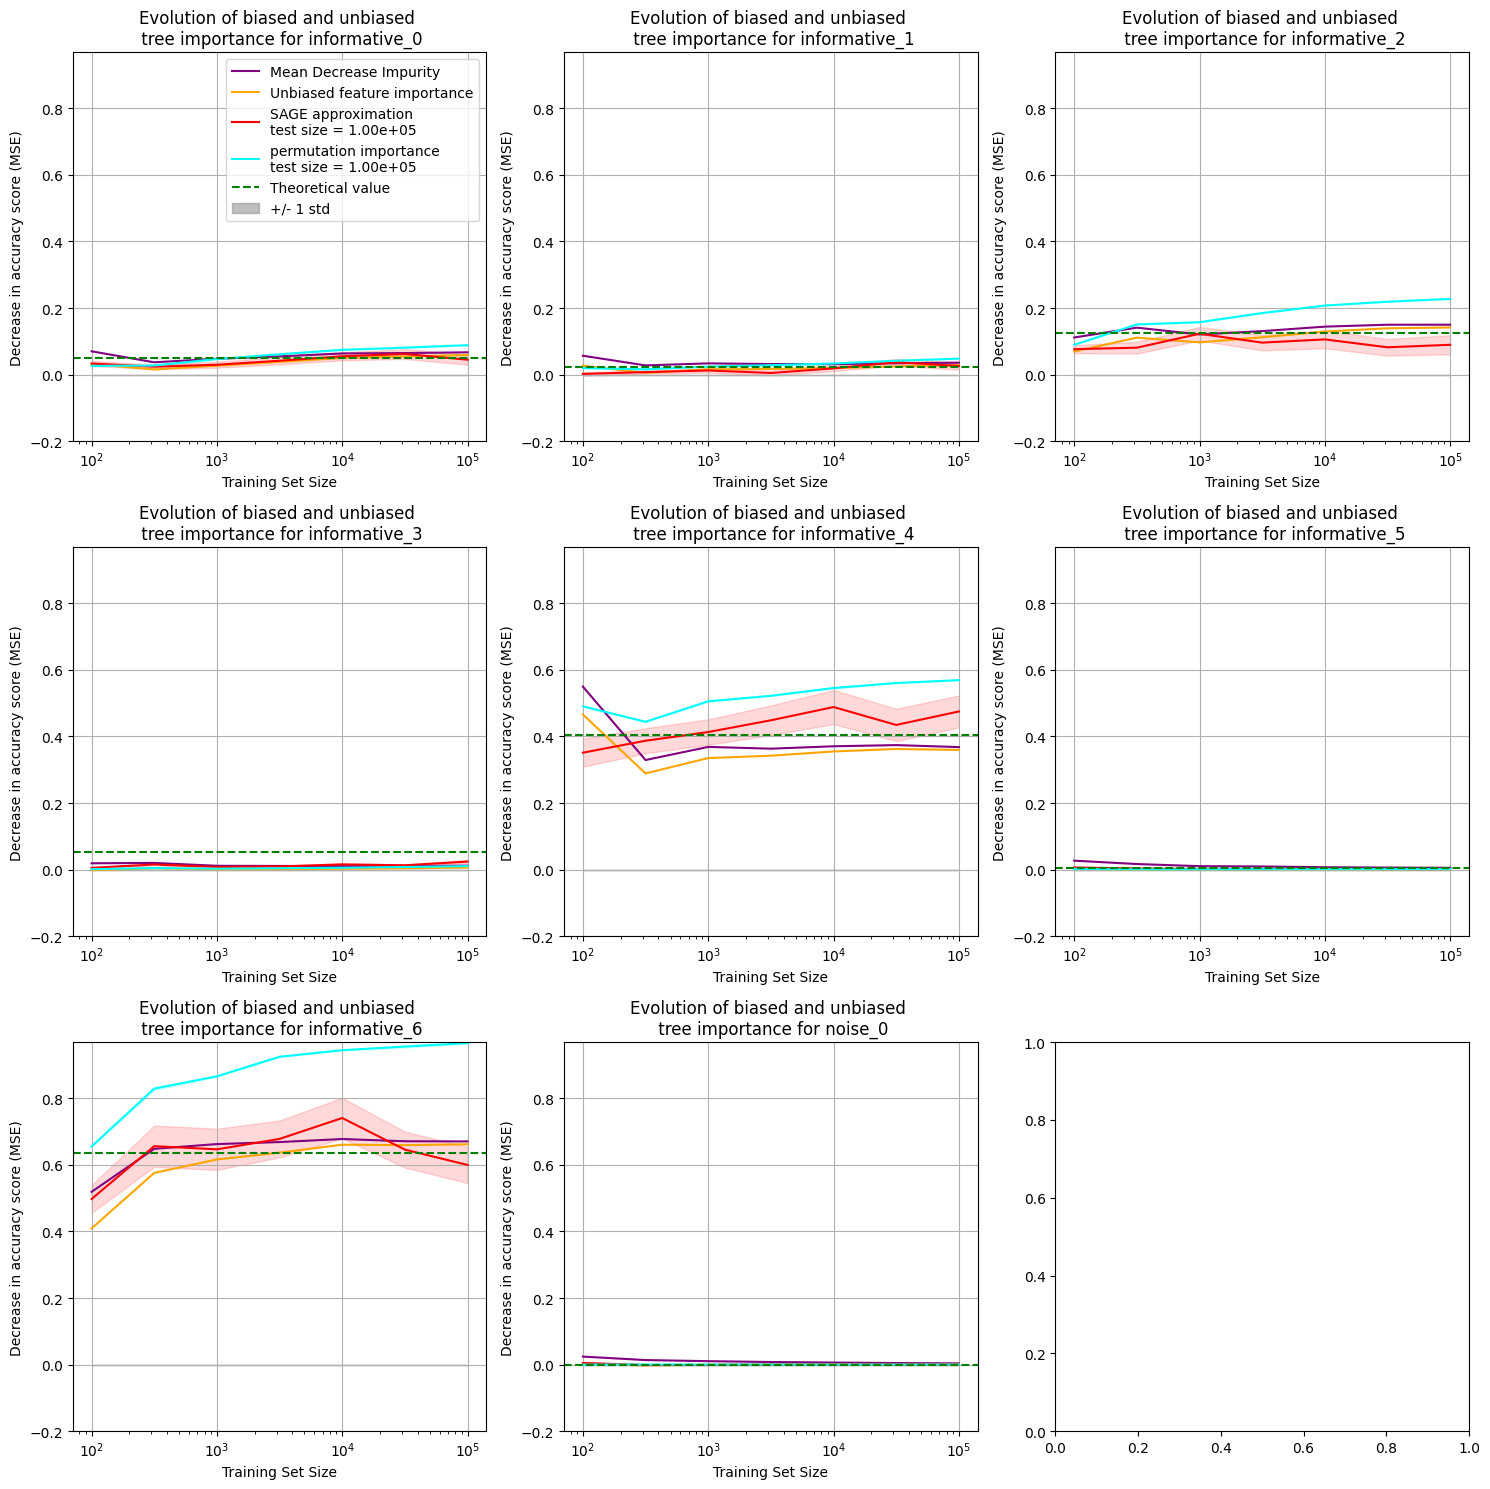

In [7]:
global_max = np.max(
    [
        mdi_res,
        umdi_res,
        [sage_res[j].values + sage_res[j].std for j in range(len(train_sizes))],
        [
            permut_res[j].importances_mean + permut_res[j].importances_std
            for j in range(len(train_sizes))
        ],
    ]
)

# Plot
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i in range(n_feature):
    axs[i].set_ylim(-0.2, global_max)
    axs[i].plot(
        train_sizes, mdi_res[:, i], label="Mean Decrease Impurity", color="purple"
    )
    axs[i].plot(
        train_sizes, umdi_res[:, i], label="Unbiased feature importance", color="orange"
    )
    axs[i].plot(
        train_sizes,
        [sage_res[j].values[i] for j in range(len(train_sizes))],
        label=f"SAGE approximation \ntest size = {test_size:.2e}",
        color="red",
    )
    axs[i].fill_between(
        train_sizes,
        [sage_res[j].values[i] + sage_res[j].std[i] for j in range(len(train_sizes))],
        [sage_res[j].values[i] - sage_res[j].std[i] for j in range(len(train_sizes))],
        color="red",
        alpha=0.15,
    )
    axs[i].plot(
        train_sizes,
        [permut_res[j].importances_mean[i] for j in range(len(train_sizes))],
        label=f"permutation importance \ntest size = {test_size:.2e}",
        color="cyan",
    )
    axs[i].fill_between(
        train_sizes,
        [
            permut_res[j].importances_mean[i] + permut_res[j].importances_std[i]
            for j in range(len(train_sizes))
        ],
        [
            permut_res[j].importances_mean[i] - permut_res[j].importances_std[i]
            for j in range(len(train_sizes))
        ],
        color="cyan",
        alpha=0.15,
    )
    axs[i].axhline(exact_sage[i], ls="--", label="Theoretical value", color="green")
    # axs[i].axhline(model_weights[i], ls="-.", label="Weight in the model", color="black")
    axs[i].fill_between(train_sizes, 0, 0, color="gray", alpha=0.5, label="+/- 1 std")
    axs[i].set_xscale("log")
    axs[i].set_xlabel("Training Set Size")
    axs[i].set_ylabel("Decrease in accuracy score (MSE)")
    axs[i].set_title(
        f"Evolution of biased and unbiased \n tree importance for {feature_names[i]}"
    )
    axs[i].grid(True)
axs[0].legend()

plt.tight_layout()
plt.show()
